In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from src.TimeSeriesLearningUtils import *
from datetime import datetime

In [2]:
def get_data(currency_list,
             data_frequency,
             pred_frequency, 
             num_classes,
             window_size,
             neutral_quantile = 0.33,
             beg_date = pd.Timestamp(2017,1,1),
             end_date = pd.Timestamp.now(),
             log_price = True,
             remove_trend = False,
             decompose = False,
             ma_period = 7, #in terms of days
             indicators = False,
             imfs = False,
             ohlv = False,
              **kwargs):

        X, y, dfs = {}, {}, {}     
        
        for cur in currency_list:
            df = pd.read_csv(f"../data/0_raw/Binance/{str.lower(cur)}_usdt_{data_frequency}.csv", header=None,index_col=0)
            df.index = pd.to_datetime(df.index, unit='ms')
            df.sort_index(inplace=True)
            df.columns = ["open","high","low","close","volume"]
            
            if indicators:
                from ta import add_all_ta_features
                indicators_df = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume", fillna=True)
                df[indicators_df.columns] = indicators_df
          
            if imfs:
                from PyEMD import EEMD
                eemd = EEMD(parallel=True, processes=2)
                imfs_result = eemd(df["close"].values, max_imf=7)
                imf_features = ["imf_"+str(i) for i in range(imfs_result.shape[0])]
                df = pd.concat((df, pd.DataFrame(imfs_result.T, columns=imf_features, index=df.index)), axis=1)
            
            if log_price:
                df[["close", "open", "high", "low"]] = df[["close", "open", "high", "low"]].apply(np.log, axis=1)
                   
            if num_classes == 3:
                pct_diff = df['close'].pct_change()
                quantile_value = pct_diff.abs().quantile(neutral_quantile).loc[neutral_quantile]
                
                conditions = [(pct_diff < 0) & (pct_diff.abs() > quantile_value),
                              (pct_diff > 0) & (pct_diff.abs() > quantile_value)]

                classes = [0,1] # 2 is the default class if none of conditions is met, i.e. price change in the neutral range
            
                change_dir = np.select(conditions, classes, default=2)
            
            else: 
                change_dir = df['close'].diff().apply(lambda x: 0 if x <= 0 else 1)
            
            df.insert(loc=0, column="change_dir", value=change_dir)   
            
            if remove_trend:
                #from statsmodels.tsa.seasonal import seasonal_decompose
                #ma_period = ma_period if pred_frequency in ['d', 'D'] else ma_period * 4
                #components = seasonal_decompose(df["close"], model="additive", period = ma_period, two_sided=False)
                #df["close"] -= components.trend
                df['diff'] = df['close'].diff()
                #df['diff'] = df['close'].pct_change()
                if not decompose:
                    df.drop('close', axis=1, inplace=True)  

            if decompose: 
                from statsmodels.tsa.seasonal import seasonal_decompose
                ma_period = ma_period if pred_frequency == '1d' else ma_period * 4 #if pred_frequency is 6h, then multiply the ma_period by 4 
                components = seasonal_decompose(df["close"], model="additive", period = ma_period, two_sided=False)
                df['trend'] = components.trend
                df['residual'] = components.resid  
                df['seasonal'] = components.seasonal

            if ohlv: #keeping open, high, low, and volume
                df[['open_d', 'high_d', 'low_d', 'volume_d']] = df[["open", "high", "low", "volume"]].diff() 
            else:
                df.drop(["open", "high", "low", "volume"], axis=1, inplace=True)
            
            dfs[cur] = df.dropna()
        
        min_dates = [df.index.min() for cur, df in dfs.items()]
        max_dates = [df.index.max() for cur, df in dfs.items()]
        beg_date = max([max(min_dates), beg_date])
        end_date = min([min(max_dates), end_date])
        common_range = pd.date_range(beg_date, end_date, freq=data_frequency)
        
        missing = set()
        common_set = set(common_range)
        for cur, df in dfs.items():
            missing_steps = common_set.difference(df.index)
            missing |= missing_steps
        common_range = common_range.drop(missing)
        
        X = np.array([dfs[cur].loc[common_range].drop(["change_dir"], axis=1).values for cur in currency_list])
        y = np.array([dfs[cur].loc[common_range, "change_dir"].values for cur in currency_list])
        features = df.columns.tolist()
        features.remove("change_dir")

        return X, y, features, dfs, common_range

In [3]:
def get_data2(currency_list,
             data_frequency,
             pred_frequency,
             num_classes,
             window_size,
             neutral_quantile = 0.33,
             beg_date = pd.Timestamp(2017,1,1),
             end_date = pd.Timestamp.now(),
             log_price = True,
             remove_trend = False,
             ma_period = 0,
             include_indicators = False,
             include_imfs = False,
             ohlv = False,
             drop_missing = True,
              **kwargs):

        X, y, dfs = {}, {}, {}     
        
        for cur in currency_list:
            df = pd.read_csv(f"../data/0_raw/Binance/{str.lower(cur)}_usdt_{data_frequency}.csv", header=None,index_col=0)
            df.index = pd.to_datetime(df.index, unit='ms')
            df.sort_index(inplace=True)
            df.columns = ["open","high","low","close","volume"]
            
            if include_indicators:
                from ta import add_all_ta_features
                indicators_df = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume", fillna=True)
                df[indicators_df.columns] = indicators_df
            
            if include_imfs:
                from PyEMD import EEMD
                eemd = EEMD(parallel=True, processes=2)
                imfs = eemd(df["close"].values, max_imf=7)
                imf_features = ["imf_"+str(i) for i in range(imfs.shape[0])]
                df = pd.concat((df, pd.DataFrame(imfs.T, columns=imf_features, index=df.index)), axis=1)
            
            if log_price:
                df[["close", "open", "high", "low"]] = df[["close", "open", "high", "low"]].apply(np.log, axis=1)
                   
            if num_classes == 3:
                df['pct_diff'] = df['close'].pct_change()
                neutral_quantiles = df['pct_diff'].abs().quantile(neutral_quantile).loc[neutral_quantile]

                conditions = [(df['pct_diff'] < 0) & (df['pct_diff'].abs() > neutral_quantiles),
                              (df['pct_diff'] > 0) & (df['pct_diff'].abs() > neutral_quantiles)]

                classes = [0,1] # 2 is the default class if none of conditions is met, i.e. price change in the neutral range
            
                change_dir = np.select(conditions, classes, default=2)
            
            else:
                df['diff'] = df['close'].diff()
                change_dir = df['diff'].apply(lambda x: 0 if x <= 0 else 1)
            
            df.insert(loc=0, column="change_dir", value=change_dir)   
            df.dropna(inplace=True)  
            
            if remove_trend:
                from statsmodels.tsa.seasonal import seasonal_decompose
                components = seasonal_decompose(df["close"].values, period=3, model="additive")#, period = ma_period, two_sided=False)
                df["close"] -= components.trend
                df.dropna(inplace=True)
                
            if not ohlv: #keeping open, high, low, and volume
                df.drop(["open", "high", "low", "volume"], axis=1, inplace=True)

            dfs[cur] = df
        
        min_dates = [df.index.min() for cur, df in dfs.items()]
        max_dates = [df.index.max() for cur, df in dfs.items()]
        beg_date = max([max(min_dates), beg_date])
        end_date = min([min(max_dates), end_date])
        common_range = pd.date_range(beg_date, end_date, freq=data_frequency)
        
        missing = set()
        common_set = set(common_range)
        for cur, df in dfs.items():
            missing_steps = common_set.difference(df.index)
            missing |= missing_steps
        common_range = common_range.drop(missing)
        
        diff_col = 'pct_diff' if num_classes == 3 else 'diff'

        X = np.array([dfs[cur].loc[common_range].drop(["change_dir", diff_col], axis=1).values for cur in currency_list])
        y = np.array([dfs[cur].loc[common_range, "change_dir"].values for cur in currency_list])
        features = df.columns.tolist()
        features.remove("change_dir")
        
        return X, y, features, dfs, common_range

In [7]:
CURRENCY_LST = ['BTC', 'ETH', 'LTC', 'XRP', 'ADA']
num_classes = 2
DATA_FREQ = '1d'
PRED_FREQ = '1d'
WINDOW_SIZE = 400
NEUTRAL_QUANTILE = 0.33,
dataset_percentages = [0.90, 0.0, 0.1]
train_pct = 0.9
LOOK_AHEAD = 3

In [8]:
X, y, features, dfs, common_range = get_data(currency_list= CURRENCY_LST,
                               data_frequency=DATA_FREQ,
                               pred_frequency=PRED_FREQ,
                               num_classes = num_classes, 
                               window_size = WINDOW_SIZE,
                               neutral_quantile = NEUTRAL_QUANTILE,
                               log_price = True,
                               remove_trend = True,
                               ma_period = 7,
                               indicators = False,
                               imfs = False,
                               decompose = False,
                               ohlv = False,
                               beg_date = pd.Timestamp(2017,1,1),
                               end_date = pd.Timestamp(2022,1,1))

train_dataset, val_dataset, test_dataset = [TimeSeriesDataset(X, y, dtype, CURRENCY_LST, dataset_percentages, WINDOW_SIZE, DATA_FREQ, PRED_FREQ) for dtype in ['train', 'val', 'test']]

In [12]:
X.shape

(5, 1197, 1)

In [7]:
df = dfs['BTC']
df.describe()

,change_dir,diff
count,1460.000000,1460.000000
mean,0.530822,0.001648
std,0.499220,0.043587
min,0.000000,-0.502607
25%,0.000000,-0.015750
50%,1.000000,0.001810
75%,1.000000,0.019939
max,1.000000,0.202952


In [13]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [14]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier

In [15]:
LOOK_AHEAD=6
data = {}
for i, cur in enumerate(CURRENCY_LST):
    seq_X = rolling_window(X[i].squeeze(), WINDOW_SIZE)[:-1]
    
    train_size = int(len(seq_X) * train_pct)
    test_size = len(seq_X) - train_size

    data[cur] = pd.DataFrame(np.hstack((seq_X, y[i][WINDOW_SIZE:].reshape(-1,1))))
    X_train = seq_X[:train_size]
    X_test = seq_X[train_size-WINDOW_SIZE:]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = y[i][WINDOW_SIZE:train_size+WINDOW_SIZE]
    y_test = y[i][train_size:]
    lr = LogisticRegression()
    lr.fit(X_train[:-LOOK_AHEAD], y_train[LOOK_AHEAD:])
    print(cur)
    #print(lr.coef_)
    print(lr.score(X_train[:-LOOK_AHEAD], y_train[LOOK_AHEAD:]))
    print(lr.score(X_test[:-LOOK_AHEAD], y_test[LOOK_AHEAD:]))

BTC
0.9353023909985936
0.8734177215189873
ETH
0.9563994374120957
0.8881856540084389
LTC
0.929676511954993
0.8586497890295358
XRP
0.8987341772151899
0.8396624472573839
ADA
0.9240506329113924
0.8502109704641351


In [16]:
data = {}
for i, cur in enumerate(CURRENCY_LST):
    seq_X = rolling_window(X[i].squeeze(), WINDOW_SIZE)[:-1]

    train_size = int(len(seq_X) * train_pct)
    test_size = len(seq_X) - train_size

    data[cur] = pd.DataFrame(np.hstack((seq_X, y[i][WINDOW_SIZE:].reshape(-1,1))))
    X_train = seq_X[:train_size]
    X_test = seq_X[train_size-WINDOW_SIZE:]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    y_train = y[i][WINDOW_SIZE:train_size+WINDOW_SIZE]
    y_test = y[i][train_size:]
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    print(cur)
    #print(lr.coef_)
    print(lr.score(X_train, y_train))
    print(lr.score(X_test, y_test))

BTC
0.9274755927475593
0.8770833333333333
ETH
0.9567642956764296
0.8916666666666667
LTC
0.9400278940027894
0.8541666666666666
XRP
0.9316596931659693
0.8645833333333334
ADA
0.9567642956764296
0.88125


In [17]:
data = {}
for i, cur in enumerate(CURRENCY_LST):
    seq_X = rolling_window(X[i].squeeze(), WINDOW_SIZE)[:-1]
    
    train_size = int(len(seq_X) * train_pct)
    test_size = len(seq_X) - train_size

    data[cur] = pd.DataFrame(np.hstack((seq_X, y[i][WINDOW_SIZE:].reshape(-1,1))))
    X_train = seq_X[:train_size]
    X_test = seq_X[train_size-WINDOW_SIZE:]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    y_train = y[i][WINDOW_SIZE:train_size+WINDOW_SIZE]
    y_test = y[i][train_size:]
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)
    rf.fit(X_train, y_train)
    print(cur)
    print(rf.score(X_train, y_train))
    print(rf.score(X_test, y_test))

BTC
1.0
0.9166666666666666
ETH
1.0
0.9354166666666667
LTC
1.0
0.9104166666666667
XRP
1.0
0.9104166666666667
ADA
1.0
0.9166666666666666


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

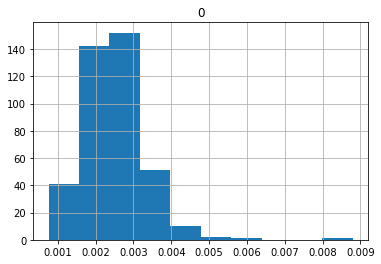

In [18]:
pd.DataFrame(rf.feature_importances_).hist()

In [19]:
np.argmax(rf.feature_importances_)

399

In [20]:
data = {}
for i, cur in enumerate(CURRENCY_LST):
    seq_X = rolling_window(X[i].squeeze(), WINDOW_SIZE)[:-1]
    
    train_size = int(len(seq_X) * train_pct)
    test_size = len(seq_X) - train_size

    data[cur] = pd.DataFrame(np.hstack((seq_X, y[i][WINDOW_SIZE:].reshape(-1,1))))
    X_train = seq_X[:train_size]
    X_test = seq_X[train_size-WINDOW_SIZE:]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    y_train = y[i][WINDOW_SIZE:train_size+WINDOW_SIZE]
    y_test = y[i][train_size:]
    xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    xgb.fit(X_train, y_train)
    print(cur)
    print(xgb.score(X_train, y_train))
    print(xgb.score(X_test, y_test))

BTC
1.0
0.9125
ETH
1.0
0.91875
LTC
1.0
0.9166666666666666
XRP
1.0
0.9208333333333333
ADA
1.0
0.9083333333333333


In [72]:
#!pip install -U numpy==1.18 --user #required if keras produces an error related to numpy

In [21]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Bidirectional

In [ ]:
batch_size = 16
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(WINDOW_SIZE, 1))))
#model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(200,WINDOW_SIZE, 1))))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
# fit model
model.fit(X_train.reshape(X_train.shape[0],-1,1), 
          y_train, 
          epochs=30, 
          batch_size=batch_size, 
          verbose=2,
         validation_data=(X_test.reshape(X_test.shape[0],-1,1), y_test))

In [22]:
X_train.reshape(X_train.shape[0],-1,1).shape

(717, 400, 1)

In [23]:
batch_size = 8
model = Sequential()
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_test, y_test))

Epoch 1/20
90/90 - 2s - loss: 0.8139 - acc: 0.4937 - val_loss: 0.4028 - val_acc: 0.8583
Epoch 2/20
90/90 - 0s - loss: 0.3647 - acc: 0.8842 - val_loss: 0.2854 - val_acc: 0.9333
Epoch 3/20
90/90 - 0s - loss: 0.2191 - acc: 0.9833 - val_loss: 0.2333 - val_acc: 0.9312
Epoch 4/20
90/90 - 0s - loss: 0.1297 - acc: 0.9986 - val_loss: 0.2125 - val_acc: 0.9271
